# Quark-Gluon with ResNet (Classical)

This is just for comparison with the classical ViT.

In [1]:
import flax.linen as nn
import jax
import jax.numpy as jnp
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')  # Ensure TF does not see GPU and grab all GPU memory.
tf.random.set_seed(42)  # For reproducibility.

from quantum_transformers.utils import plot_image
from quantum_transformers.datasets import get_quark_gluon_dataloaders
from quantum_transformers.training import train_and_evaluate

data_dir = '/global/cfs/cdirs/m4392/salcc/data'

2023-09-26 11:59:34.129218: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-26 11:59:34.129250: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-26 11:59:34.129272: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-26 11:59:34.946474: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Please first ``pip install -U cirq`` to enable related functionality in translation module


In [2]:
for d in jax.devices():
    print(d, d.device_kind)

gpu:0 NVIDIA A100-PCIE-40GB


Cardinalities (train, val, test): 714510 79390 139306


(125, 125, 3)


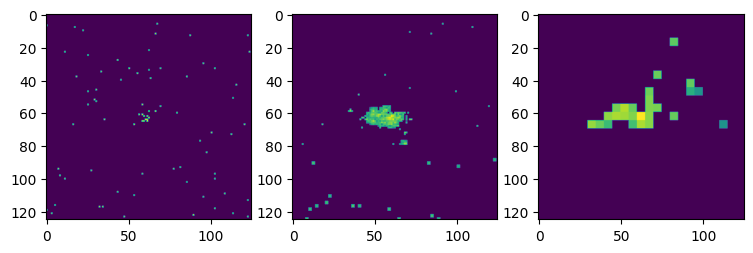

In [3]:
qg_train_dataloader, qg_val_dataloader, qg_test_dataloader = get_quark_gluon_dataloaders(batch_size=256, data_dir=data_dir)
first_image = next(iter(qg_train_dataloader))[0][0]
print(first_image.shape)
plot_image(first_image, abs_log=True)

In [4]:
class ResidualBlock(nn.Module):
    channels: int
    strides: tuple[int, int] = (1, 1)
    
    @nn.compact
    def __call__(self, x):
        residual = x

        # If strides are not 1, or channels changed, adapt the residual path
        if x.shape[-1] != self.channels or self.strides != (1, 1):
            residual = nn.Conv(features=self.channels, kernel_size=(1, 1), strides=self.strides)(residual)

        x = nn.Conv(features=self.channels, kernel_size=(3, 3), strides=self.strides, padding="SAME")(x)
        x = nn.relu(x)
        x = nn.Conv(features=self.channels, kernel_size=(3, 3), strides=(1, 1), padding="SAME")(x)
        x = x + residual
        x = nn.relu(x)
        return x

class ResNet15(nn.Module):
    num_classes: int
    channels_last: bool = True

    @nn.compact
    def __call__(self, x, **_):
        if not self.channels_last:
            x = x.transpose((0, 3, 1, 2))
        # x.shape = (batch_size, height, width, num_channels)

        x = nn.Conv(features=16, kernel_size=(7, 7), strides=(2, 2), padding="SAME")(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(3, 3), strides=(2, 2), padding="SAME")

        x = ResidualBlock(channels=16, strides=(1, 1))(x)
        x = ResidualBlock(channels=16, strides=(1, 1))(x)
        x = ResidualBlock(channels=16, strides=(1, 1))(x)
        
        x = ResidualBlock(channels=32, strides=(2, 2))(x)

        x = ResidualBlock(channels=32, strides=(1, 1))(x)
        x = ResidualBlock(channels=32, strides=(1, 1))(x)
        x = ResidualBlock(channels=32, strides=(1, 1))(x)

        x = jnp.max(x, axis=(1, 2))  # Global Max Pooling

        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.num_classes)(x)

        return x

In [5]:
model = ResNet15(num_classes=2)
train_and_evaluate(model, qg_train_dataloader, qg_val_dataloader, qg_test_dataloader, num_classes=2, num_epochs=30)

Number of parameters = 107202


Epoch  30/30: 100%|██████████| 2791/2791 [01:10<00:00, 39.72batch/s, Loss = 0.5368, AUC = 80.87%]


Total training time = 2092.43s, best validation AUC = 81.15% at epoch 10


Testing: 100%|██████████| 544/544 [00:26<00:00, 20.51batch/s, Loss = 0.5365, AUC = 80.76%]


In [16]:
class ResNet15(nn.Module):
    num_classes: int
    channels_last: bool = True

    @nn.compact
    def __call__(self, x, **_):
        if not self.channels_last:
            x = x.transpose((0, 3, 1, 2))
        # x.shape = (batch_size, height, width, num_channels)

        x = nn.Conv(features=4, kernel_size=(7, 7), strides=(2, 2), padding="SAME")(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(3, 3), strides=(2, 2), padding="SAME")

        x = ResidualBlock(channels=4, strides=(1, 1))(x)
        x = ResidualBlock(channels=4, strides=(1, 1))(x)
        x = ResidualBlock(channels=4, strides=(1, 1))(x)
        
        x = ResidualBlock(channels=4, strides=(2, 2))(x)

        x = ResidualBlock(channels=8, strides=(1, 1))(x)
        x = ResidualBlock(channels=8, strides=(1, 1))(x)
        x = ResidualBlock(channels=8, strides=(1, 1))(x)

        x = jnp.max(x, axis=(1, 2))  # Global Max Pooling

        x = nn.Dense(features=8)(x)
        x = nn.relu(x)
        x = nn.Dense(features=4)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.num_classes)(x)

        return x

In [17]:
model = ResNet15(num_classes=2)
train_and_evaluate(model, qg_train_dataloader, qg_val_dataloader, qg_test_dataloader, num_classes=2, num_epochs=30)

Number of parameters = 5170


Epoch  30/30: 100%|██████████| 2791/2791 [00:43<00:00, 64.73batch/s, Loss = 0.5365, AUC = 80.70%]


Total training time = 1408.95s, best validation AUC = 80.71% at epoch 25


Testing: 100%|██████████| 544/544 [00:16<00:00, 32.43batch/s, Loss = 0.5413, AUC = 80.33%]
